In [1]:
# run this same experiment again but instead of 2,0,0 -> 0,0,2 have 2,0,0 -> 0,1,1 this would be cool 
# declaring all dependancies    
import qutip as qt
import numpy as np
from quantum_logical.pulsesim import QuantumSystem, Pulse
from quantum_logical.pulsesim.mode import QubitMode, SNAILMode, CavityMode
from quantum_logical.pulsesim.build_hamiltonian import Build_hamiltonian
import matplotlib.pyplot as plt
from qutip import Options
from tqdm import tqdm_notebook as tqdm
from progressbar import progressbar
from multiprocessing.pool import ThreadPool, Pool
import threading

opts = Options(nsteps=1e6, atol=1e-8, rtol=1e-6)
p_bar = qt.ui.TextProgressBar()  # None

c:\Users\girgi\Desktop\Github\quantum_logical\venv\lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


In [12]:
# adding all of the necessary elements to the full creation of the system 
qubit_dim = 2

# frequencies 
w1_un = 4
w2_un = 6
w3_un = 4.6666666666666666
ws_un = 5.6666666666666666

# coupling strength coefficient 
g1s = 2 * np.pi * 0.05467
g2s = 2 * np.pi * 0.0435
g3s = 2 * np.pi * 0.04875

# create array of the coefficients should be useful 
gs = [g1s, g2s, g3s]

# unknown value as of now 
g3 = .1

In [13]:
# creating the qubits and the hilbert space
qubit1 = QubitMode(
    mode_type="Qubit", name="q1", dim=qubit_dim, freq=w1_un, alpha=-0.161, T1=1e2, T2=5e1
)
qubit2 = QubitMode(
    mode_type="Qubit", name="q2", dim=qubit_dim, freq=w2_un, alpha=-0.1275, T1=1e2, T2=5e1
)
qubit3 = QubitMode(
    mode_type="Qubit", name="q3", dim=qubit_dim, freq=w3_un, alpha=-0.160, T1=1e2, T2=5e1
)
qubits = [qubit1, qubit2, qubit3]
snail = SNAILMode(mode_type="Snail", name="s", freq=ws_un, g3=0.3, dim=10, T1=1e3, T2=5e2)
_couplings = {
    frozenset([qubit1, snail]): 2 * np.pi * 0.05467,
    frozenset([qubit2, snail]): 2 * np.pi * 0.0435,
    frozenset([qubit3, snail]): 2 * np.pi * 0.04875
}

qs = QuantumSystem(qubits + [snail], couplings=_couplings)

system = []
system.extend(qubits)
system.extend([snail])

In [14]:
# list of qubit coupling strengths that will be given
g13 = g23 = g12 = .01
gqs = [[qubit1.freq,g12,g13],[g12,qubit2.freq,g23],[g13,g23,qubit3.freq]]

# creating the list of alphas that will be given to us 
a1 = a2 = a3 = .1
alphas = [a1, a2, a3]

In [15]:
# building the hammiltonian up to the pump term 
# creating the linear parts of the hamiltonian  
# the qubit and snail separate terms
H_no_interaction = [(i.freq / (2 * np.pi)) * (qs.modes_a_dag[i] * qs.modes_a[i]) for i in system]

# creating the snail mixing with the qubits terms
H_snail_qubits = [gs[qubits.index(i)] * (qs.modes_field[snail] * qs.modes_field[i]) for i in qubits]

# adding the coupling terms between the qubits 
H_qubit_qubit = []

for i in range(len(qubits)):
    for j in range(len(qubits)):
        if j > i:
            H_qubit_qubit.append(gqs[i][j] * (qs.modes_field[qubits[i]] * qs.modes_field[qubits[j]]))

# creating the nonlinear parts of the hamiltonian 
# adding the snail third order term first 
H_snail_third = [g3 * ((qs.modes_field[snail]) ** 3)]

# add the qubit non-linearity 
H_qubit_fourth = [alphas[qubits.index(i)] * (qs.modes_field[i] ** 4) for i in qubits]

In [16]:
H_total_no_time = []
# adding the linear parts into the hamiltonian 
H_total_no_time.extend(H_no_interaction)
H_total_no_time.extend(H_snail_qubits)
H_total_no_time.extend(H_qubit_qubit)
# adding the non-linear parts 
H_total_no_time.extend(H_snail_third)
H_total_no_time.extend(H_qubit_fourth)

In [17]:
H_no_time = sum(H_total_no_time)

In [18]:
# adding the time dependent terms 
# this might have to be done with a constant pulse first but it should be easy to implement the more complex ones 

H_time = (qs.modes_a[snail] * qs.modes_a[snail] + qs.modes_a_dag[snail] * qs.modes_a_dag[snail])

# making a pulse for the function 
def w_t(a, b, t):
    # return a * np.sin(b * t)
    return a * np.sin(b * t)

amp = 0.631578947368421
freq = 0.6578947368421052 
def wt(t, args = None):
    return w_t(amp, freq, t)

H = [H_no_time,[H_time, wt]]



In [19]:
# create the intial state 
psi0 = qt.tensor(qt.basis(qubit_dim,1), qt.basis(qubit_dim,0), qt.basis(qubit_dim,0), qt.basis(snail.dim))
rho0 = psi0 * psi0.dag()

In [22]:
# # run mesolve over the hamiltonian 
tlist = np.linspace(0,1000,200)
result = qt.mesolve(H = H_no_time, rho0 = psi0, tlist = tlist, options= opts, progress_bar = True)

10.1%. Run time:   0.12s. Est. time left: 00:00:00:01
20.1%. Run time:   0.30s. Est. time left: 00:00:00:01
30.2%. Run time:   0.48s. Est. time left: 00:00:00:01
40.2%. Run time:   0.66s. Est. time left: 00:00:00:00
50.3%. Run time:   0.88s. Est. time left: 00:00:00:00
60.3%. Run time:   1.13s. Est. time left: 00:00:00:00
70.4%. Run time:   1.38s. Est. time left: 00:00:00:00
80.4%. Run time:   1.64s. Est. time left: 00:00:00:00
90.5%. Run time:   1.89s. Est. time left: 00:00:00:00
100.0%. Run time:   2.13s. Est. time left: 00:00:00:00
Total run time:   2.13s


C:\Users\girgi\AppData\Local\Temp\ipykernel_11884\1901212009.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


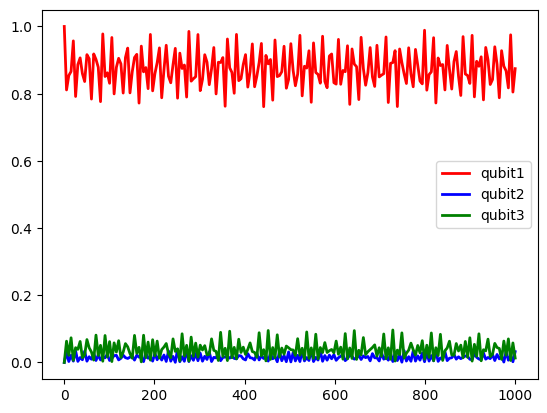

In [23]:
fig, ax = plt.subplots()
ax.plot(tlist, np.real(qt.expect(qs.modes_a_dag[qubit1]*qs.modes_a[qubit1], result.states)), 'r', linewidth = 2, label = "qubit1")
ax.plot(tlist, np.real(qt.expect(qs.modes_a_dag[qubit2]*qs.modes_a[qubit2], result.states)), 'b', linewidth = 2, label = "qubit2")
ax.plot(tlist, np.real(qt.expect(qs.modes_a_dag[qubit3]*qs.modes_a[qubit3], result.states)), 'g', linewidth = 2, label = "qubit3")
# ax.plot(tlist, np.real(qt.expect(qs.modes_a_dag[snail]*qs.modes_a[snail], result.states)), 'y', linewidth = 2, label = "snail")
ax.legend()
fig.show()

In [31]:
# creating the expected final state 
psif = qt.tensor(qt.basis(qubit_dim,0), qt.basis(qubit_dim,0), qt.basis(qubit_dim,2), qt.basis(snail.dim))
rhof = psif * psif.dag()
psif = qt.ptrace(psif, [0,1,2])

In [32]:
qt.fidelity(psif, qt.ptrace(result.states[-1],[0,1,2]))

0.18939251591077047

In [33]:
# will optimize over the amplitude of the pulse and maybe frequency 
# creating the tuple of amps and frequencies 
amps = np.linspace(0, 4, 5)
freqs = np.linspace(0, 2.5, 5)
amps_freqs = [(i,j) for i in amps for j in freqs]

def sim_task(amp, freq):

    # def w_t(a, b, t):
    #     return a * np.sin(b * t)
    def w_t(a,b, t):
        return a * np.sin(b * t)

    def wt(t, args = None):
        return w_t(amp, freq, t)
    
    H_pump = [H_time, wt]

    H_t = [H_no_time, H_pump]

    res = qt.mesolve(H = H_t, rho0 = psi0, tlist = tlist, options= opts)

    # add the fid calculation
    fid = qt.fidelity(qt.ptrace(res.states[-1],[0,1,2]), psif)
    print("hi")

    return amp, freq, fid


In [34]:
# process the data 
fids = []
freq_res = []
amp_res = []


# for i in range(len(results)):
#     fids.append(results[i][2])
#     amp_res.append(results[i][0])
#     freq_res.append(results[i][1])

# max(fids)

In [35]:
# print("the amplitude and freq at the max are %s and %s " %(amp_res[fids.index(max(fids))], freq_res[fids.index(max(fids))]))

In [36]:
threads = [threading.Thread(target=sim_task, args=(amp_freq[0], amp_freq[1])) for amp_freq in amps_freqs]
# starting the threads 
[tr.start() for tr in threads]
[tr.join() for tr in threads]



c:\Users\girgi\Desktop\Github\quantum_logical\venv\lib\site-packages\scipy\integrate\_ode.py:431: UserWarning: _zvode: Repeated error test failures. (Check all input.)
  self._y, self.t = mth(self.f, self.jac or (lambda: None),
Exception in thread Thread-47:
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\girgi\Desktop\Github\quantum_logical\venv\lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\girgi\AppData\Local\Temp\ipykernel_18140\3649231807.py", line 21, in sim_task
  File "c:\Users\girgi\Desktop\Github\quantum_logical\venv\lib\site-packages\qutip\solver\mesolve.py"

In [ ]:
# results_parallel.get()